In [1]:
!pip install pulp

In [2]:
import json
import os
import matplotlib.pyplot as plt
from pulp import *
from collections import defaultdict

In [3]:
import json, os

CONFIG_PATH = r"C:\Users\HP\Downloads\cityflow.config"

with open(CONFIG_PATH) as f:
    config = json.load(f)

# Extract useful values
DT = config["interval"]
FLOW_PATH = os.path.join(config["dir"], config["flowFile"])
ROADNET_PATH = os.path.join(config["dir"], config["roadnetFile"])


In [5]:
print("\u2705 Loaded roadnet and flow data\n")

✅ Loaded roadnet and flow data



In [37]:
print("Number of routes:", len(flow_data))
print("Number of intersections:", len(roadnet_data["intersections"]))

Number of routes: 2983
Number of intersections: 32


In [6]:
intersections = roadnet_data["intersections"]
traffic_light_info = {}

for inter in intersections:
    if inter['virtual']:  # skip virtual nodes
        continue
    inter_id = inter['id']
    light_phases = inter.get('trafficLight', {}).get('lightphases', [])
    phases = [ph['time'] for ph in light_phases]  # extract green/red times
    traffic_light_info[inter_id] = phases

print("\u2705 Extracted light phase timing for intersections\n")


✅ Extracted light phase timing for intersections



In [39]:
# Example output
example = list(traffic_light_info.items())[0]
print(f"Sample Intersection: {example[0]}")
print(f"Phase Durations: {example[1]}\n")

Sample Intersection: intersection_1_1
Phase Durations: [5, 30, 30, 30, 30, 30, 30, 30, 30]



In [8]:
# Parse Roads & Lane Connections
# ---------------------------------------------
road_links = defaultdict(list)
for road in roadnet_data['roads']:
    start = road['startIntersection']
    end = road['endIntersection']
    road_links[start].append(end)

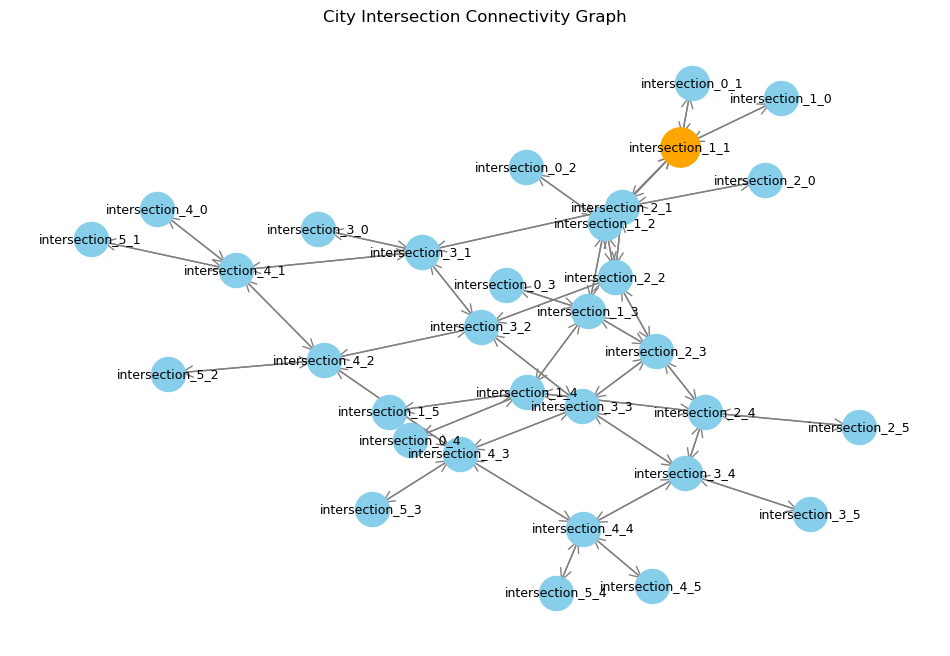

In [40]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict

# Step 1: Build road_links dictionary again
road_links = defaultdict(list)
for road in roadnet_data['roads']:
    start = road['startIntersection']
    end = road['endIntersection']
    road_links[start].append(end)

# Step 2: Create Directed Graph
G = nx.DiGraph()

# Add nodes and edges
for start, ends in road_links.items():
    for end in ends:
        G.add_edge(start, end)

# Step 3: Draw the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)  # spring layout for clarity

# Draw nodes and edges
nx.draw_networkx_nodes(G, pos, node_size=600, node_color='skyblue')
nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=20, edge_color='gray')
nx.draw_networkx_labels(G, pos, font_size=9)

# Highlight one key intersection (e.g. intersection_1_1)
if 'intersection_1_1' in G.nodes:
    nx.draw_networkx_nodes(G, pos, nodelist=['intersection_1_1'], node_color='orange', node_size=800)

plt.title("City Intersection Connectivity Graph")
plt.axis('off')
plt.show()


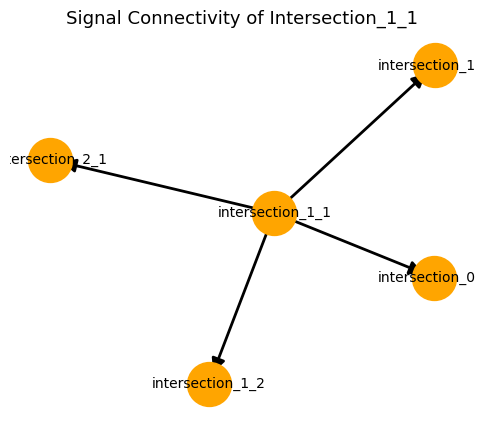

In [41]:
import networkx as nx
import matplotlib.pyplot as plt

# Choose your focus intersection
focus = 'intersection_1_1'
neighbors = road_links[focus]

# Create small directed graph
G_focus = nx.DiGraph()
for end in neighbors:
    G_focus.add_edge(focus, end)

# Plot
plt.figure(figsize=(6, 5))
pos = nx.spring_layout(G_focus, seed=1)

nx.draw_networkx_nodes(G_focus, pos, node_color='orange', node_size=1000)
nx.draw_networkx_edges(G_focus, pos, arrowstyle='-|>', arrowsize=20, edge_color='black', width=2)
nx.draw_networkx_labels(G_focus, pos, font_size=10)

plt.title("Signal Connectivity of Intersection_1_1", fontsize=13)
plt.axis('off')
plt.show()

In [9]:
# Parse Vehicle Flow Data
# ---------------------------------------------
vehicle_flows = flow_data
arrival_table = defaultdict(list)

for vehicle in vehicle_flows:
    time = vehicle['startTime']
    start = vehicle['route'][0]
    arrival_table[start].append(time)

In [42]:
# Step 2: Show summary
print(f"\n✅ Total roads with arriving vehicles: {len(arrival_table)}\n")

# Step 3: Show top 3 roads with sample arrival times
print("🚗 Sample Vehicle Arrivals:\n")
for road, times in list(arrival_table.items())[:3]:
    times.sort()
    print(f"🛣️ {road} → {len(times)} vehicles")
    print(f"   Arrival times: {times[:10]}...\n")


✅ Total roads with arriving vehicles: 9

🚗 Sample Vehicle Arrivals:

🛣️ road_4_0_1 → 207 vehicles
   Arrival times: [0, 13, 26, 39, 52, 65, 78, 91, 104, 117]...

🛣️ road_0_1_0 → 398 vehicles
   Arrival times: [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]...

🛣️ road_5_4_2 → 617 vehicles
   Arrival times: [0, 7, 14, 21, 28, 35, 42, 49, 56, 63]...



In [43]:
# Convert arrival times to histogram style
arrival_demand = {
    link: len(times) for link, times in arrival_table.items()
}

In [44]:
# Top 5 busiest roads
sorted_arrivals = sorted(arrival_demand.items(), key=lambda x: x[1], reverse=True)
print("Top 5 busiest incoming links:")
for road, count in sorted_arrivals[:5]:
    print(f"{road}: {count} vehicles")

Top 5 busiest incoming links:
road_0_4_0: 729 vehicles
road_5_4_2: 617 vehicles
road_0_1_0: 398 vehicles
road_5_3_2: 230 vehicles
road_0_2_0: 214 vehicles


In [12]:
# ---------------------------------------------
# Save preprocessed data for optimization phase
# ---------------------------------------------
preprocessed_data = {
    'traffic_light_info': traffic_light_info,
    'arrival_demand': arrival_demand,
    'busiest_roads': sorted_arrivals[:10],
}

In [13]:
with open("preprocessed_data.json", "w") as f:
    json.dump(preprocessed_data, f, indent=2)

print("\n✅ Preprocessed data saved to preprocessed_data.json")


✅ Preprocessed data saved to preprocessed_data.json


In [45]:
with open("preprocessed_data.json") as f:
    preprocessed_data = json.load(f)

traffic_light_info = preprocessed_data['traffic_light_info']
arrival_demand = preprocessed_data['arrival_demand']


In [46]:
# Choose Intersection to Optimize
# ---------------------------------------------
intersection_id = "intersection_1_1"
original_durations = traffic_light_info[intersection_id] 

In [47]:
# Remove yellow phase (assume it's first 5 sec)
safe_time = original_durations[0]
green_phases = original_durations[1:]  # Assume 8 green phases
num_phases = len(green_phases)

In [17]:
# Simplified Phase Demand Mapping
# Assign top 8 roads to 8 phases (1-to-1 mapping)
sorted_roads = sorted(arrival_demand.items(), key=lambda x: x[1], reverse=True)
phase_to_road = {f"P{i+1}": sorted_roads[i][0] for i in range(min(num_phases, len(sorted_roads)))}

In [18]:
# Demand per phase
phase_demand = {phase: arrival_demand.get(road, 0) for phase, road in phase_to_road.items()}

In [48]:
print("\n🔀 Phase-to-Road Mapping (Optimizing Intersection: intersection_1_1):\n")
for phase, road in phase_to_road.items():
    print(f"  🔁 {phase} → {road}  ({arrival_demand[road]} vehicles)")


🔀 Phase-to-Road Mapping (Optimizing Intersection: intersection_1_1):

  🔁 P1 → road_0_4_0  (729 vehicles)
  🔁 P2 → road_5_4_2  (617 vehicles)
  🔁 P3 → road_0_1_0  (398 vehicles)
  🔁 P4 → road_5_3_2  (230 vehicles)
  🔁 P5 → road_0_2_0  (214 vehicles)
  🔁 P6 → road_5_2_2  (214 vehicles)
  🔁 P7 → road_4_0_1  (207 vehicles)
  🔁 P8 → road_1_0_1  (187 vehicles)


C:\Users\HP\AppData\Local\Temp\ipykernel_9568\3290907188.py:13: UserWarning: Glyph 128678 (\N{VERTICAL TRAFFIC LIGHT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\HP\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128678 (\N{VERTICAL TRAFFIC LIGHT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


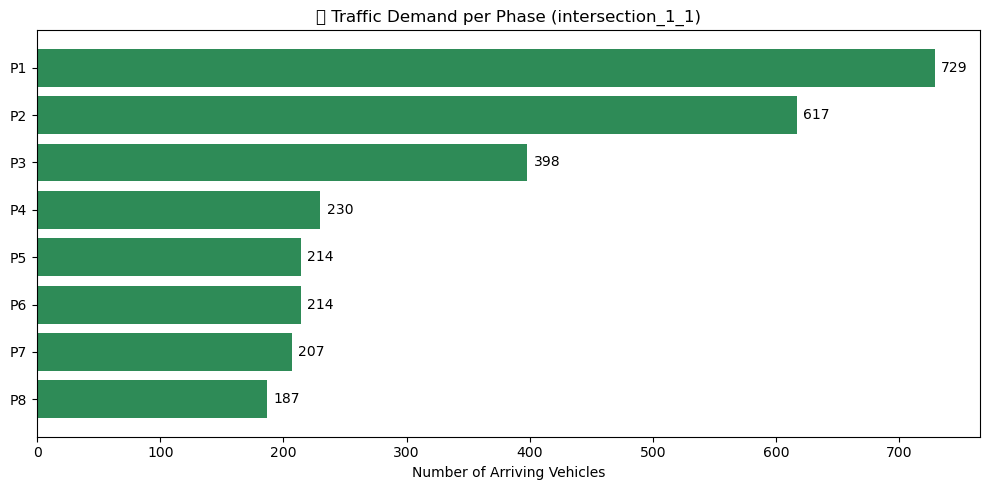

In [49]:
import matplotlib.pyplot as plt

phases = list(phase_to_road.keys())
vehicles = [arrival_demand[road] for road in phase_to_road.values()]

plt.figure(figsize=(10, 5))
plt.barh(phases, vehicles, color='seagreen')
plt.xlabel("Number of Arriving Vehicles")
plt.title("🚦 Traffic Demand per Phase (intersection_1_1)")
for i, v in enumerate(vehicles):
    plt.text(v + 5, i, str(v), va='center')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [59]:
import pulp

In [75]:
# Constants
TOTAL_GREEN_TIME = 240  # or sum(green_phases), fixed total cycle
SAT_RATE = 0.5         # Increased from 0.5 to 1.0 for better realism
MIN_GREEN = 10
MAX_GREEN = 60

# MILP Model
model = pulp.LpProblem("TrafficSignalOptimization", pulp.LpMaximize)

# Variables
green_vars = {}
served_vars = {}
for phase in phase_to_road:
    green_vars[phase] = pulp.LpVariable(f"green_{phase}", lowBound=MIN_GREEN, upBound=MAX_GREEN)
    served_vars[phase] = pulp.LpVariable(f"served_{phase}", lowBound=0)

# 🎯 Objective: Weighted Max Vehicles Served (priority to high-demand phases)
model += pulp.lpSum([served_vars[phase] * phase_demand[phase] for phase in phase_to_road])

# 🔒 Constraint 1: Total Green Time
model += pulp.lpSum([green_vars[phase] for phase in phase_to_road]) == TOTAL_GREEN_TIME

# 🔒 Constraint 2: Served ≤ Saturation * Green Time
for phase in phase_to_road:
    model += served_vars[phase] <= SAT_RATE * green_vars[phase]

# 🔒 Constraint 3: Served ≤ Actual Demand
for phase in phase_to_road:
    model += served_vars[phase] <= phase_demand[phase]


In [76]:
# Solve model
model.solve()

1

In [77]:
print("\n✅ MILP Optimization Completed:")
optimized_green = {phase: green_vars[phase].varValue for phase in green_vars}
optimized_served = {phase: served_vars[phase].varValue for phase in served_vars}


✅ MILP Optimization Completed:


In [78]:
print(f"\n🛑 Optimization Results for Intersection: {intersection_id}\n")
print(f"{'Phase':<5}  {'Green Time (s)':<15}  {'Served Vehicles':<18}  {'Demand':<10}  {'% Served':<10}  {'Incoming Road'}")
print("-" * 90)

for phase in phase_to_road:
    green = optimized_green[phase]
    served = optimized_served[phase]
    demand = phase_demand[phase]
    road = phase_to_road[phase]
    percent_served = (served / demand) * 100 if demand > 0 else 0
    
    print(f"{phase:<5}  {green:<15.2f}  {served:<18.1f}  {demand:<10}  {percent_served:<10.1f}  {road}")


🛑 Optimization Results for Intersection: intersection_1_1

Phase  Green Time (s)   Served Vehicles     Demand      % Served    Incoming Road
------------------------------------------------------------------------------------------
P1     60.00            30.0                729         4.1         road_0_4_0
P2     60.00            30.0                617         4.9         road_5_4_2
P3     60.00            30.0                398         7.5         road_0_1_0
P4     20.00            10.0                230         4.3         road_5_3_2
P5     10.00            5.0                 214         2.3         road_0_2_0
P6     10.00            5.0                 214         2.3         road_5_2_2
P7     10.00            5.0                 207         2.4         road_4_0_1
P8     10.00            5.0                 187         2.7         road_1_0_1


In [79]:
import json
from datetime import datetime

# Save result
output = {
    "intersection": intersection_id,
    "optimized_green": optimized_green,
    "optimized_served": optimized_served,
    "phase_to_road": phase_to_road,
    "demand": phase_demand,
    "timestamp": datetime.now().isoformat(),  # 🕒 ISO format timestamp
    "total_served": sum(optimized_served.values())  # 🚗 Total vehicles served
}

with open("optimized_milp_output.json", "w") as f:
    json.dump(output, f, indent=2)

print("\n✅ Optimized MILP result saved to optimized_milp_output.json")


✅ Optimized MILP result saved to optimized_milp_output.json


In [80]:
served_baseline = {}
for i, phase in enumerate(phase_to_road):
    original_green = green_phases[i]
    max_serve = SAT_RATE * original_green
    served_baseline[phase] = min(max_serve, phase_demand[phase])


In [81]:
print("\n📊 Queue Length Comparison (Before vs After):")
queue_before = {}
queue_after = {}
for phase in phase_to_road:
    road = phase_to_road[phase]
    demand = phase_demand[phase]
    queue_before[road] = max(0, demand - served_baseline[phase])
    queue_after[road] = max(0, demand - optimized_served[phase])
    print(f"{road}: Queue Before = {queue_before[road]}, Queue After = {queue_after[road]}")


📊 Queue Length Comparison (Before vs After):
road_0_4_0: Queue Before = 714.0, Queue After = 699.0
road_5_4_2: Queue Before = 602.0, Queue After = 587.0
road_0_1_0: Queue Before = 383.0, Queue After = 368.0
road_5_3_2: Queue Before = 215.0, Queue After = 220.0
road_0_2_0: Queue Before = 199.0, Queue After = 209.0
road_5_2_2: Queue Before = 199.0, Queue After = 209.0
road_4_0_1: Queue Before = 192.0, Queue After = 202.0
road_1_0_1: Queue Before = 172.0, Queue After = 182.0


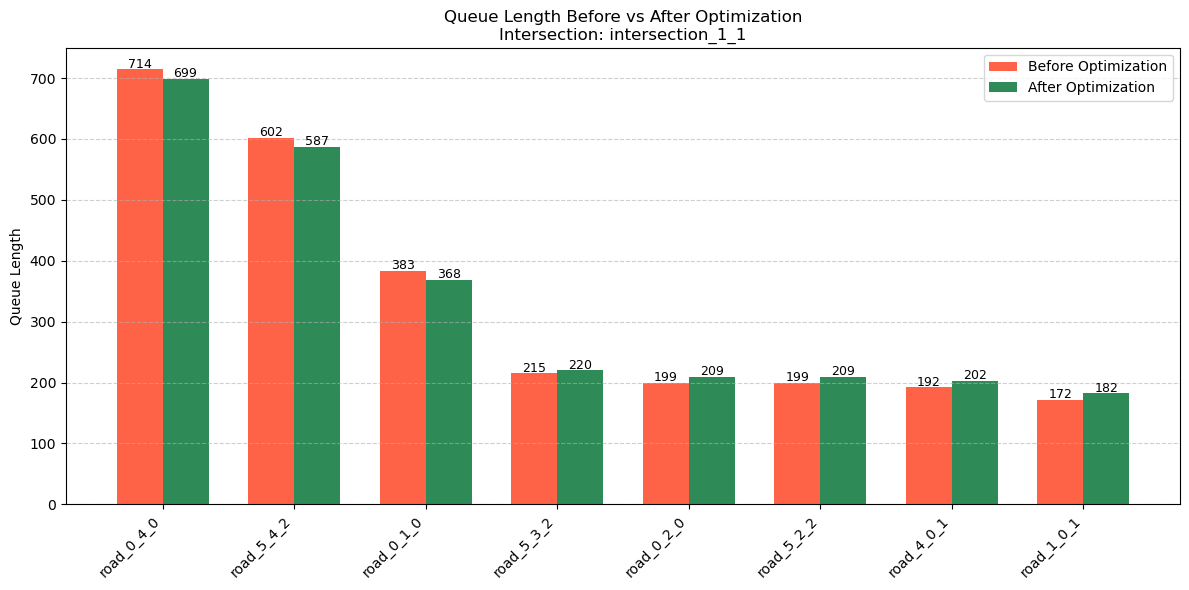

In [82]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare data
roads = list(queue_before.keys())
before_queues = [queue_before[r] for r in roads]
after_queues = [queue_after[r] for r in roads]

x = np.arange(len(roads))  # label locations
width = 0.35  # bar width

# Plot
plt.figure(figsize=(12, 6))
bar1 = plt.bar(x - width/2, before_queues, width, label='Before Optimization', color='tomato')
bar2 = plt.bar(x + width/2, after_queues, width, label='After Optimization', color='seagreen')

# Labels and formatting
plt.ylabel('Queue Length')
plt.title(f'Queue Length Before vs After Optimization\nIntersection: {intersection_id}')
plt.xticks(x, roads, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Add values on top of bars
for i in range(len(roads)):
    plt.text(x[i] - width/2, before_queues[i] + 3, str(int(before_queues[i])), ha='center', fontsize=9)
    plt.text(x[i] + width/2, after_queues[i] + 3, str(int(after_queues[i])), ha='center', fontsize=9)

# Show plot
plt.show()

Queue lengths may increase for some roads and decrease for others because the total green time is fixed. The optimizer allocates more green time to high-demand roads to serve more vehicles overall, which can cause slightly longer queues on lower-demand roads. This trade-off improves overall intersection flow, even if not all queues reduce simultaneously.


📊 Base Cycle Time (240s):
Total Demand: 2796 vehicles
Total Served Before Optimization: 120.0
Total Served After Optimization : 120.0
% Improvement: 0.00%
Total Delay Before: 2676.0 vehicles
Total Delay After : 2676.0 vehicles

📊 Relaxed Cycle Time (300s):
Total Demand: 2796 vehicles
Total Served Before Optimization: 120.0
Total Served After Optimization : 150.0
% Improvement: 25.00%
Total Delay Before: 2676.0 vehicles
Total Delay After : 2646.0 vehicles


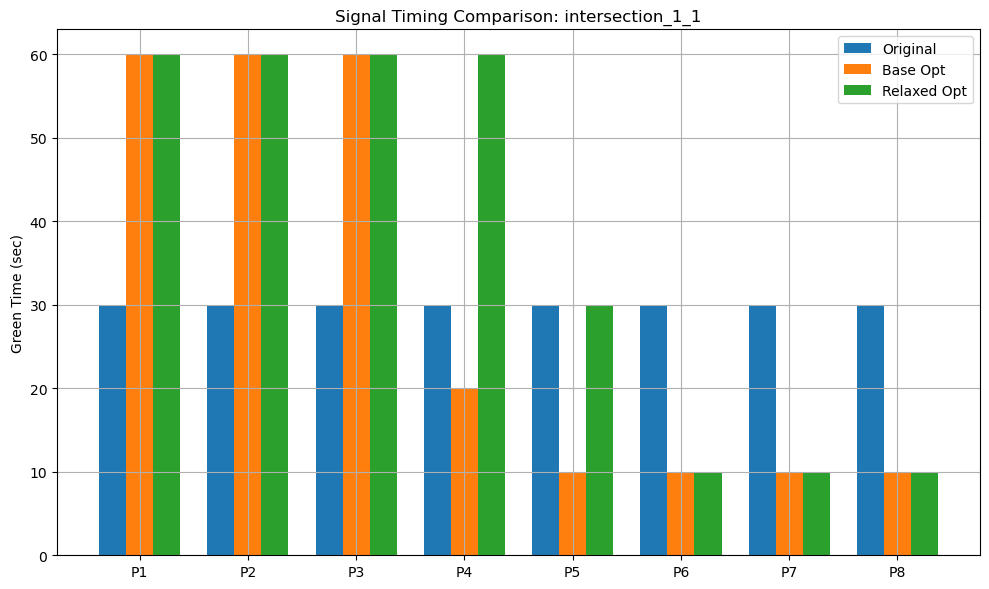

In [35]:
# ---------------------------------------------
# Constraint Tuning – Compare Base vs Relaxed Optimization
# ---------------------------------------------
def run_optimization(cycle_time, sat_rate):
    model = pulp.LpProblem("TrafficSignalOptimization", 1)  # 1 = Maximize
    green_vars = {}
    served_vars = {}

    for phase in phase_to_road:
        green_vars[phase] = pulp.LpVariable(f"green_{phase}", lowBound=10, upBound=60)
        served_vars[phase] = pulp.LpVariable(f"served_{phase}", lowBound=0)

    model += pulp.lpSum([served_vars[phase] for phase in phase_to_road])
    model += pulp.lpSum([green_vars[phase] for phase in phase_to_road]) == cycle_time

    for phase in phase_to_road:
        model += served_vars[phase] == sat_rate * green_vars[phase]
        model += served_vars[phase] <= phase_demand[phase]

    model.solve()

    optimized_green = {phase: green_vars[phase].varValue for phase in green_vars}
    optimized_served = {phase: served_vars[phase].varValue for phase in served_vars}
    return optimized_green, optimized_served

# Base: 240s cycle
BASE_GREEN = sum(green_phases)
SAT_RATE = 0.5
opt_base_green, opt_base_served = run_optimization(BASE_GREEN, SAT_RATE)

# Relaxed: 300s cycle
RELAXED_GREEN = 300
opt_relaxed_green, opt_relaxed_served = run_optimization(RELAXED_GREEN, SAT_RATE)

# -----------------------------
# Comparison Summary Function
# -----------------------------
def compare_summary(opt_served, label):
    served_baseline = {}
    for i, phase in enumerate(phase_to_road):
        original_green = green_phases[i]
        max_serve = SAT_RATE * original_green
        served_baseline[phase] = min(max_serve, phase_demand[phase])

    total_demand = sum(phase_demand.values())
    total_served_before = sum(served_baseline.values())
    total_served_after = sum(opt_served.values())
    total_delay_before = total_demand - total_served_before
    total_delay_after = total_demand - total_served_after

    print(f"\n📊 {label}:")
    print(f"Total Demand: {total_demand:.0f} vehicles")
    print(f"Total Served Before Optimization: {total_served_before:.1f}")
    print(f"Total Served After Optimization : {total_served_after:.1f}")
    print(f"% Improvement: {100 * (total_served_after - total_served_before) / total_served_before:.2f}%")
    print(f"Total Delay Before: {total_delay_before:.1f} vehicles")
    print(f"Total Delay After : {total_delay_after:.1f} vehicles")

# Display Results
compare_summary(opt_base_served, "Base Cycle Time (240s)")
compare_summary(opt_relaxed_served, "Relaxed Cycle Time (300s)")

# -----------------------------
# Visualization of Green Times
# -----------------------------
labels = list(phase_to_road.keys())
orig = green_phases[:len(labels)]
base = [opt_base_green[p] for p in labels]
relaxed = [opt_relaxed_green[p] for p in labels]

x = range(len(labels))
plt.figure(figsize=(10, 6))
plt.bar(x, orig, width=0.25, label="Original", align='center')
plt.bar([i + 0.25 for i in x], base, width=0.25, label="Base Opt", align='center')
plt.bar([i + 0.50 for i in x], relaxed, width=0.25, label="Relaxed Opt", align='center')
plt.xticks([i + 0.25 for i in x], labels)
plt.ylabel("Green Time (sec)")
plt.title(f"Signal Timing Comparison: {intersection_id}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


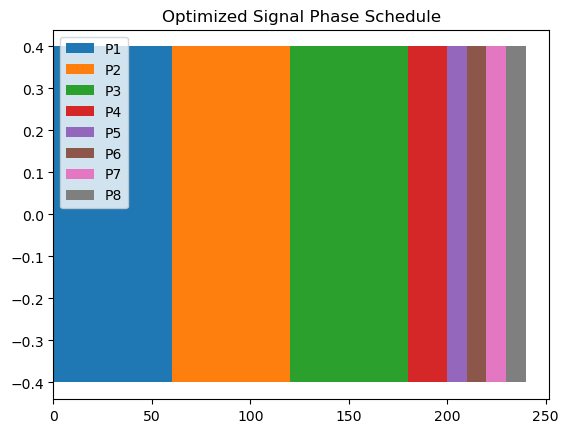

In [84]:
import matplotlib.pyplot as plt

def plot_gantt(green_times, title="Signal Schedule"):
    phases = list(green_times.keys())
    fig, ax = plt.subplots()
    start = 0
    for phase in phases:
        duration = green_times[phase]
        ax.barh(0, duration, left=start, label=phase)
        start += duration
    ax.set_title(title)
    ax.legend()
    plt.show()
plot_gantt(optimized_green, title="Optimized Signal Phase Schedule")

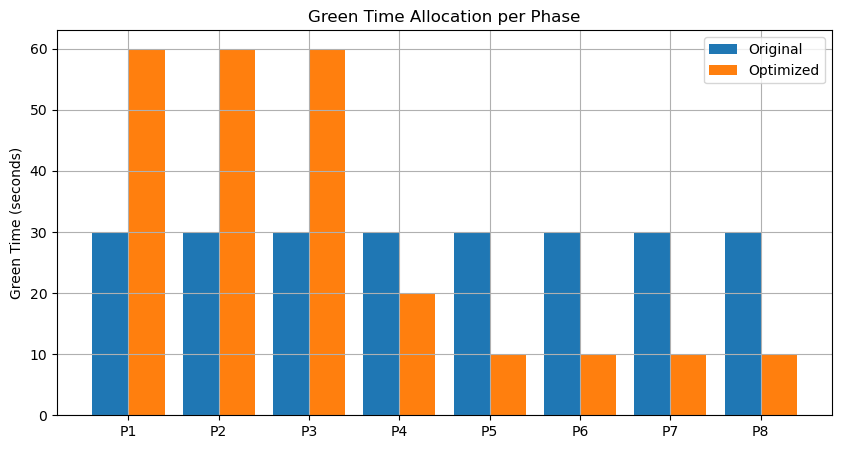

In [85]:
import matplotlib.pyplot as plt

def plot_green_time_comparison(original, optimized):
    phases = list(original.keys())
    x = range(len(phases))
    
    plt.figure(figsize=(10, 5))
    plt.bar(x, [original[p] for p in phases], width=0.4, label='Original', align='center')
    plt.bar([i + 0.4 for i in x], [optimized[p] for p in phases], width=0.4, label='Optimized', align='center')
    
    plt.xticks([i + 0.2 for i in x], phases)
    plt.ylabel("Green Time (seconds)")
    plt.title("Green Time Allocation per Phase")
    plt.legend()
    plt.grid(True)
    plt.show()

# Usage
plot_green_time_comparison(dict(zip(phase_to_road.keys(), green_phases)), opt_base_green)


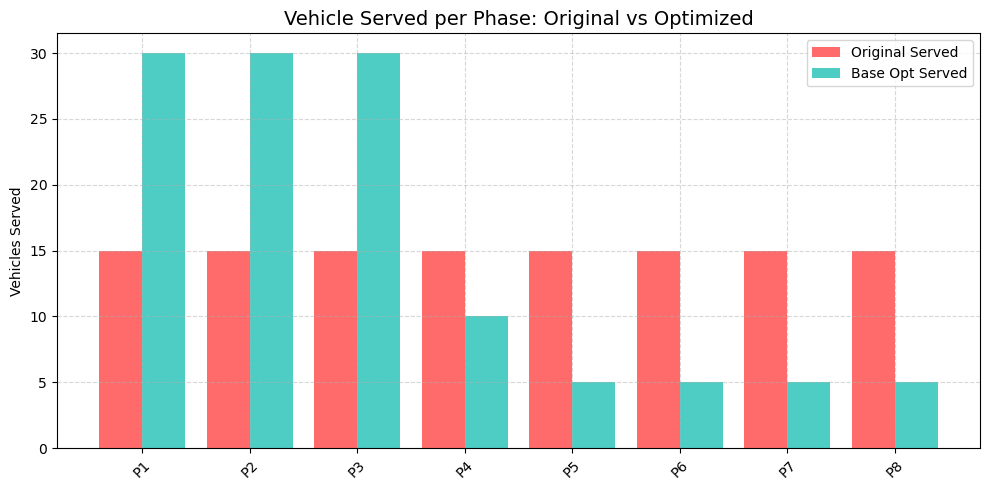

In [86]:
def plot_served_comparison(opt_served, label="Optimized"):
    served_baseline = {}
    for i, phase in enumerate(phase_to_road):
        original_green = green_phases[i]
        max_serve = SAT_RATE * original_green
        served_baseline[phase] = min(max_serve, phase_demand[phase])
    
    phases = list(phase_to_road.keys())
    x = range(len(phases))

    plt.figure(figsize=(10, 5))
    plt.bar(x, [served_baseline[p] for p in phases], width=0.4,
            label='Original Served', color='#FF6B6B', align='center')  # Soft Coral
    plt.bar([i + 0.4 for i in x], [opt_served[p] for p in phases], width=0.4,
            label=f'{label} Served', color='#4ECDC4', align='center')  # Soft Teal

    plt.xticks([i + 0.2 for i in x], phases, rotation=45)
    plt.ylabel("Vehicles Served")
    plt.title("Vehicle Served per Phase: Original vs Optimized", fontsize=14)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()
plot_served_comparison(opt_base_served, label="Base Opt")

In [87]:
def manual_check(opt_green, opt_served, phase_demand, green_phases, cycle_time, sat_rate):
    print("\n📋 Manual Model Checks:\n" + "-"*40)
    print("Function called ✅")

    # Basic input checks
    if not opt_green or not opt_served or not phase_demand:
        print("❌ One or more inputs are empty. Please check your model output.")
        return

    try:
        total_green = sum(opt_green.values())
        print(f"Total Green Time: {total_green:.2f} sec (Expected: {cycle_time})")
        if abs(total_green - cycle_time) > 1e-3:
            print("❌ Total green time does not match cycle time")

        for i, phase in enumerate(opt_green):
            g = opt_green.get(phase, 0)
            s = opt_served.get(phase, 0)
            d = phase_demand.get(phase, 0)
            sat_limit = sat_rate * g

            print(f"\n⏱️ Phase: {phase}")
            print(f"   Green Time  : {g:.2f} sec")
            print(f"   Served      : {s:.2f} vehicles")
            print(f"   Demand      : {d} vehicles")
            print(f"   Sat. Limit  : {sat_limit:.2f} vehicles")

            if g < 10 or g > 60:
                print("   ❌ Green time outside allowed bounds [10, 60]")
            if s > d + 1e-3:
                print("   ❌ Served more vehicles than demand")
            if s > sat_limit + 1e-3:
                print("   ❌ Served more than saturation limit")
            if d > 0 and g == 10:
                print("   ⚠️ Phase has demand but got minimum green time")

        print("\n✅ Manual check completed.")
    
    except Exception as e:
        print(f"❌ Error during check: {e}")

In [88]:
manual_check(
    opt_green=optimized_green,
    opt_served=optimized_served,
    phase_demand=phase_demand,
    green_phases=green_phases,
    cycle_time=TOTAL_GREEN_TIME,
    sat_rate=SAT_RATE
)


📋 Manual Model Checks:
----------------------------------------
Function called ✅
Total Green Time: 240.00 sec (Expected: 240)

⏱️ Phase: P1
   Green Time  : 60.00 sec
   Served      : 30.00 vehicles
   Demand      : 729 vehicles
   Sat. Limit  : 30.00 vehicles

⏱️ Phase: P2
   Green Time  : 60.00 sec
   Served      : 30.00 vehicles
   Demand      : 617 vehicles
   Sat. Limit  : 30.00 vehicles

⏱️ Phase: P3
   Green Time  : 60.00 sec
   Served      : 30.00 vehicles
   Demand      : 398 vehicles
   Sat. Limit  : 30.00 vehicles

⏱️ Phase: P4
   Green Time  : 20.00 sec
   Served      : 10.00 vehicles
   Demand      : 230 vehicles
   Sat. Limit  : 10.00 vehicles

⏱️ Phase: P5
   Green Time  : 10.00 sec
   Served      : 5.00 vehicles
   Demand      : 214 vehicles
   Sat. Limit  : 5.00 vehicles
   ⚠️ Phase has demand but got minimum green time

⏱️ Phase: P6
   Green Time  : 10.00 sec
   Served      : 5.00 vehicles
   Demand      : 214 vehicles
   Sat. Limit  : 5.00 vehicles
   ⚠️ Phase has 

In [36]:
# ---------------------------------------------
# Run Manual Checks for Base and Relaxed Models
# ---------------------------------------------

print("\n" + "="*60)
print("🔍 Manual Check: Base Cycle Time (240s)")
print("="*60)
manual_check(opt_base_green, opt_base_served, phase_demand, green_phases, BASE_GREEN, SAT_RATE)

print("\n" + "="*60)
print("🔍 Manual Check: Relaxed Cycle Time (300s)")
print("="*60)
manual_check(opt_relaxed_green, opt_relaxed_served, phase_demand, green_phases, RELAXED_GREEN, SAT_RATE)


🔍 Manual Check: Base Cycle Time (240s)

📋 Manual Model Checks:
----------------------------------------
Function called ✅
Total Green Time: 240.00 sec (Expected: 240)

⏱️ Phase: P1
   Green Time  : 60.00 sec
   Served      : 30.00 vehicles
   Demand      : 729 vehicles
   Sat. Limit  : 30.00 vehicles

⏱️ Phase: P2
   Green Time  : 60.00 sec
   Served      : 30.00 vehicles
   Demand      : 617 vehicles
   Sat. Limit  : 30.00 vehicles

⏱️ Phase: P3
   Green Time  : 60.00 sec
   Served      : 30.00 vehicles
   Demand      : 398 vehicles
   Sat. Limit  : 30.00 vehicles

⏱️ Phase: P4
   Green Time  : 20.00 sec
   Served      : 10.00 vehicles
   Demand      : 230 vehicles
   Sat. Limit  : 10.00 vehicles

⏱️ Phase: P5
   Green Time  : 10.00 sec
   Served      : 5.00 vehicles
   Demand      : 214 vehicles
   Sat. Limit  : 5.00 vehicles
   ⚠️ Phase has demand but got minimum green time

⏱️ Phase: P6
   Green Time  : 10.00 sec
   Served      : 5.00 vehicles
   Demand      : 214 vehicles
   Sat.